# I. Import các thư viện cần thiết

In [ ]:
!pip install catboost


In [ ]:
!pip install optuna

In [ ]:
# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Natural Language Processing (NLP)
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning Models & Pipelines
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, metrics
from sklearn.pipeline import Pipeline

# Model Evaluation & Metrics
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy import stats

# Feature Engineering & Preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Hyperparameter Tuning
import optuna


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# II. Load dữ liệu

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/NLP/Banking Sentiment Analyst /bank_reviews3.csv')

In ra số chiều của dữ liệu

In [ ]:
print(data.shape)

(1000, 10)


In ra 5 dòng đầu của dữ liệu

In [ ]:
data.head()

,author,date,address,bank,rating,review_title_by_user,review,bank_image,rating_title_by_user,useful_count
0,AMRENDRA T,"Mar 21, 2020",New delhi,SBI,4.0,"""Best saving""",State Bank Of India is located nearby in our a...,https://static.bankbazaar.com/images/common/ba...,Great!,133
1,BISHWA,"Mar 20, 2020",Kolkata,SBI,5.0,"""Good service""","I have my salary account in SBI, when I applie...",https://static.bankbazaar.com/images/common/ba...,Blown Away!,89
2,SANTOSH,"Mar 20, 2020",Hooghly,Axis Bank,5.0,"""Excellent Service""",I am using Axis bank saving account for the p...,https://static.bankbazaar.com/images/common/ba...,Blown Away!,48
3,MAHADEV,"Mar 20, 2020",Pune,HDFC Bank,5.0,"""Excellent service""",I have my salary bank account in HDFC bank for...,https://static.bankbazaar.com/images/common/ba...,Blown Away!,52
4,R,"Mar 20, 2020",Bangalore,review,5.0,"""Good account""","Close to around 10 years, I am holding this Co...",https://static.bankbazaar.com/images/common/ba...,Blown Away!,22


In [ ]:
data.describe()

,rating,useful_count
count,1000.000000,1000.000000
mean,4.351500,2.752000
std,0.940788,7.638904
min,0.500000,0.000000
25%,4.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,2.000000
max,5.000000,133.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   author                996 non-null    object 
 1   date                  1000 non-null   object 
 2   address               1000 non-null   object 
 3   bank                  1000 non-null   object 
 4   rating                1000 non-null   float64
 5   review_title_by_user  1000 non-null   object 
 6   review                1000 non-null   object 
 7   bank_image            1000 non-null   object 
 8   rating_title_by_user  1000 non-null   object 
 9   useful_count          1000 non-null   int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 78.2+ KB


In [ ]:
data.drop(columns=['bank_image'], axis=1, inplace=True)

# III. Tiền xử lí

In [ ]:
numAddress = data['address'].nunique()
numBank = data['bank'].nunique()

print(f'Bảng đánh giá được thu thập từ {numBank} ngân hàng khác nhau ở {numAddress} nơi khác nhau tại Ấn độ.')
print('Các ngân hàng đó là: ', data.bank.unique())

Bảng đánh giá được thu thập từ 10 ngân hàng khác nhau ở 107 nơi khác nhau tại Ấn độ.
Các ngân hàng đó là:  ['SBI' 'Axis Bank' 'HDFC Bank' 'review' 'IDBI' 'Kotak' 'IndusInd Bank'
 'Canara Bank' 'Citibank' 'Punjab National Bank']


In [ ]:
data['bank'].replace('review','Unknow', inplace=True)

In [ ]:
continousCol = []
categoricalCol = []
for col in data.columns:
    if data[col].dtype == 'object':
        categoricalCol.append(col)
    else:
        continousCol.append(col)

In [ ]:
continousCol

['rating', 'useful_count']

In [ ]:
categoricalCol

['author',
 'date',
 'address',
 'bank',
 'review_title_by_user',
 'review',
 'rating_title_by_user']

# EDA

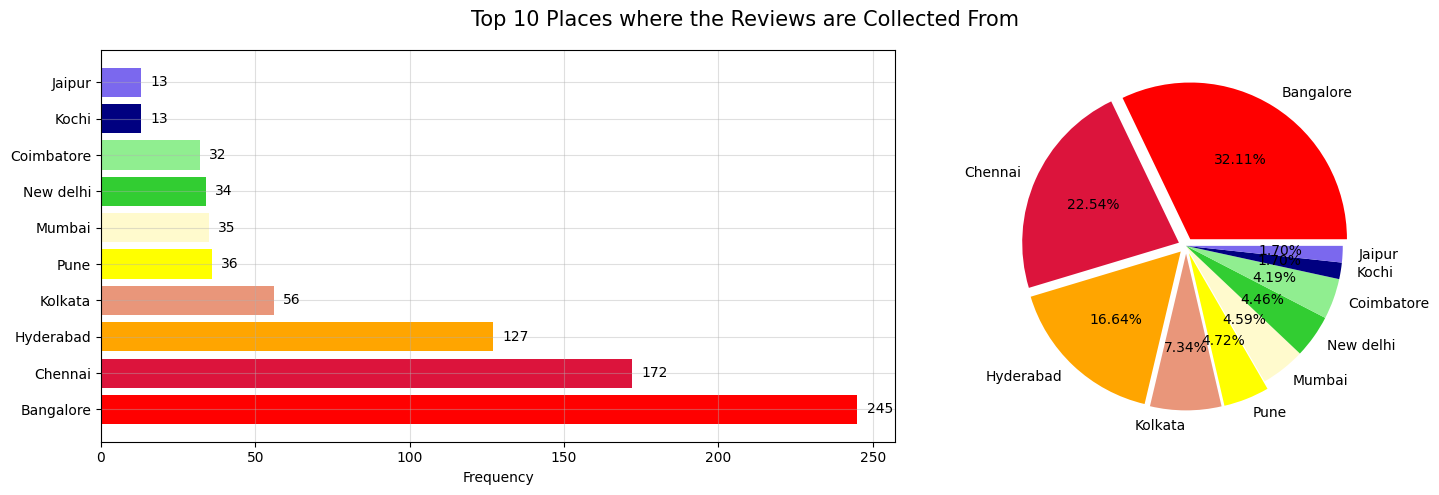

In [ ]:
address = data['address'].value_counts().sort_values(ascending=False)[:10]

colors = ['red','crimson','orange','darksalmon','yellow','lemonchiffon','limegreen','lightgreen','navy','mediumslateblue']
explodes = ([0.05]*5) + ([0]*5)

# visualization (top 10 places where the reviews are collected from)
figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[1.5,1]})
axes[0].barh(y=address.index, width=address.values, color=colors)
axes[0].set_xlabel('Frequency')

for index, values in enumerate (address):
    axes[0].text(values+3, index, str(values), va='center')

axes[0].grid(alpha=0.4)
axes[1].pie(address.values, labels=address.index, autopct='%.2f%%', explode=explodes, colors=colors)
figure.suptitle('Top 10 Places where the Reviews are Collected From', fontsize=15)
plt.tight_layout()
plt.show()

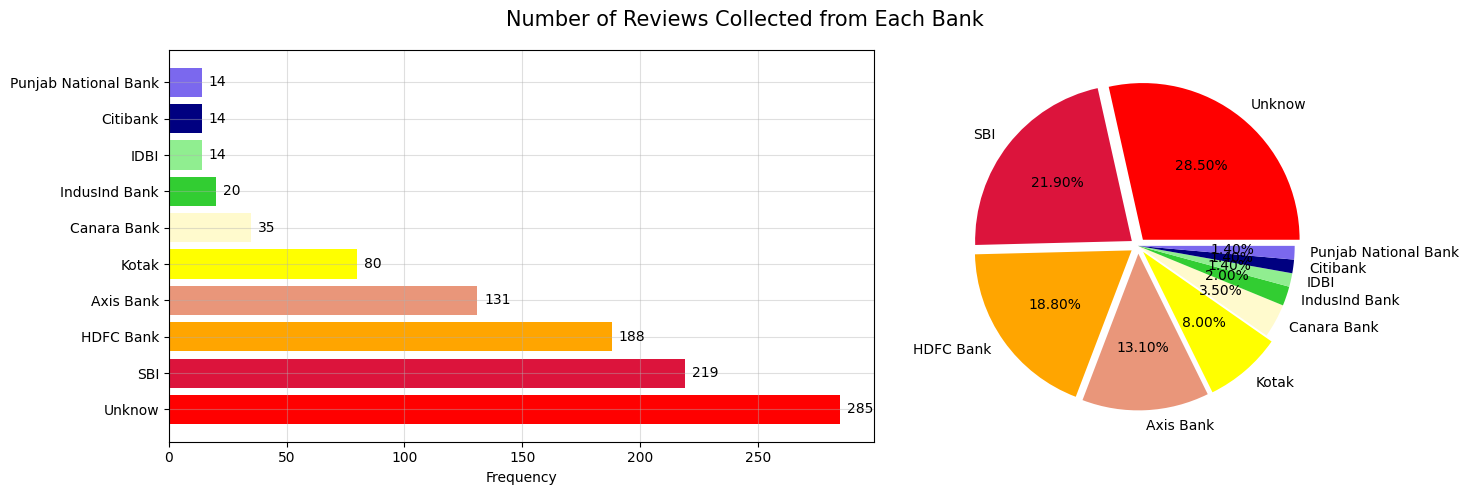

In [ ]:
# distribution of the data by 'bank'
bank = data['bank'].value_counts().sort_values(ascending=False)

# visualization in bar chart and pie chart
figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[1.5,1]})
axes[0].barh(y=bank.index, width=bank.values, color=colors)
axes[0].set_xlabel('Frequency')

for index, values in enumerate (bank):
    axes[0].text(values+3, index, str(values), va='center')

axes[0].grid(alpha=0.4)
axes[1].pie(bank.values, labels=bank.index, autopct='%.2f%%', explode=explodes, colors=colors)
figure.suptitle('Number of Reviews Collected from Each Bank', fontsize=15)
plt.tight_layout()
plt.show()

,count
rating,
5.0,550
4.0,257
3.0,71
4.5,45
2.0,30
3.5,21
1.0,13
0.5,10
2.5,2


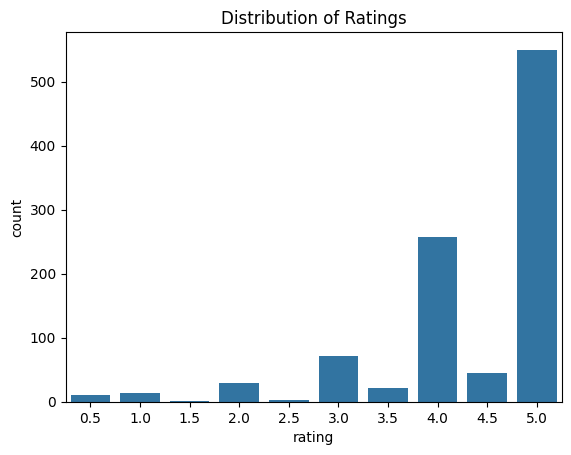

In [ ]:
sns.countplot(x='rating', data=data)
plt.title('Distribution of Ratings')
data['rating'].value_counts()

Text(0, 0.5, 'Frequency')

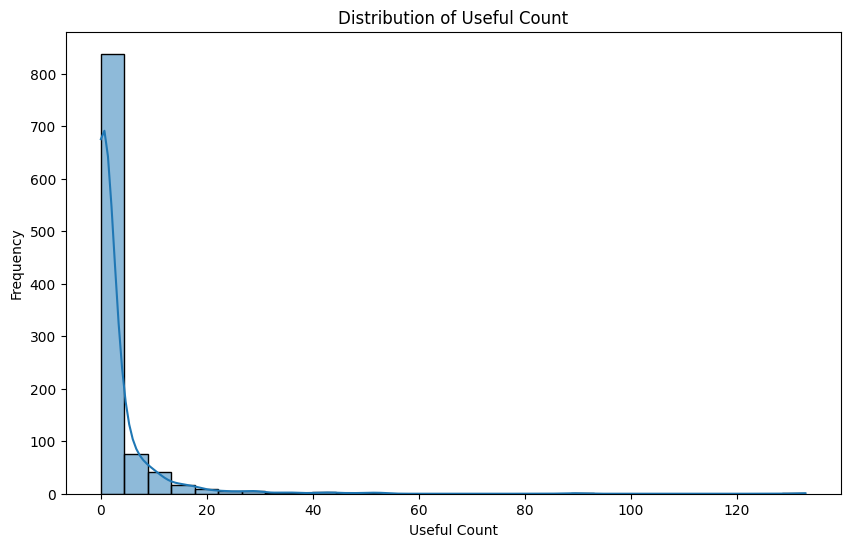

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data['useful_count'], bins=30, kde=True)
plt.title('Distribution of Useful Count')
plt.xlabel('Useful Count')
plt.ylabel('Frequency')

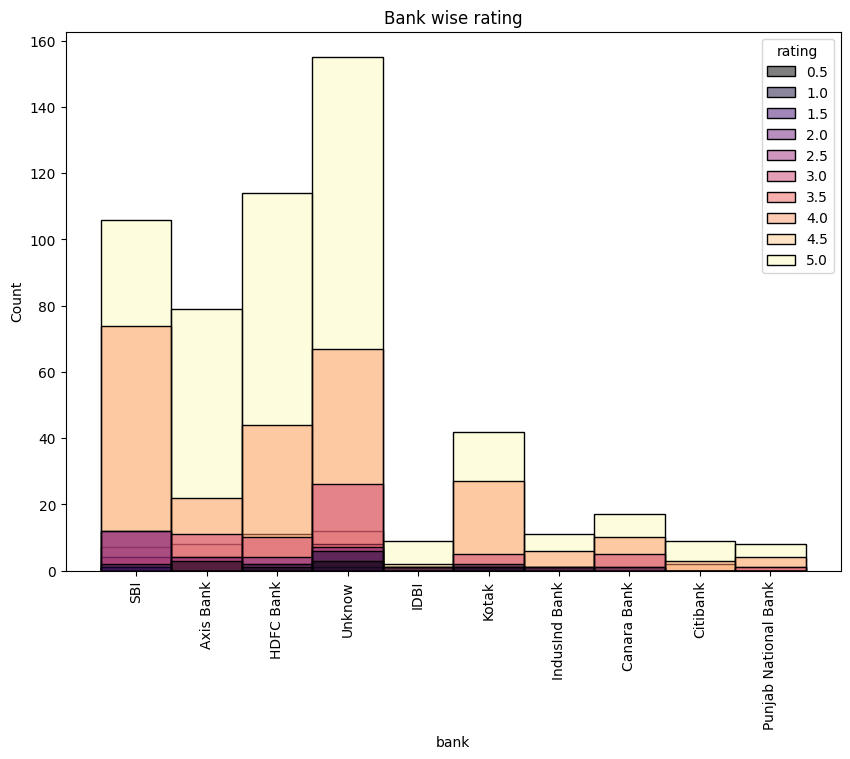

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data=data, x='bank', hue='rating', palette='magma')
plt.xticks(rotation=90)
plt.title('Bank wise rating')
plt.show()

In [ ]:
from plotly.express import line
line(data_frame=data.groupby(by='date').size().reset_index(), x='date', y=0)

In [ ]:
data['review'] = data['review'].str.replace('[^a-zA-Z0-9\s]', '')

Text(0.5, 1.0, 'Word Cloud for Reviews')

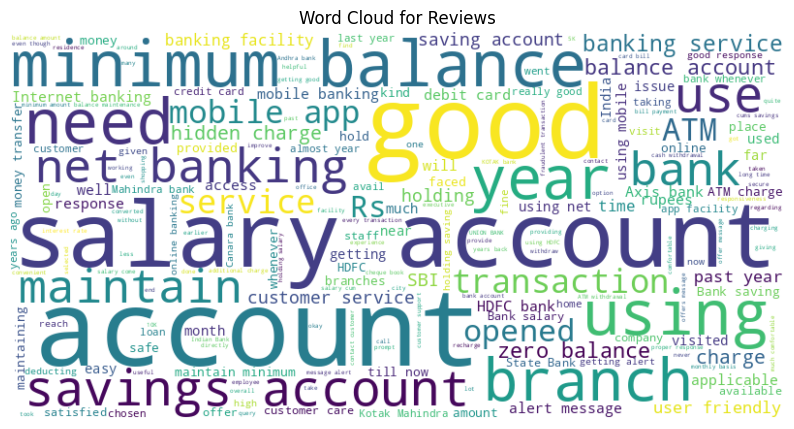

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(' '.join(data['review']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud for Reviews')

In [ ]:
# initialize the object of SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [ ]:
# calculate the polarity scores of the review
data['polarity'] = data['review'].apply(sia.polarity_scores)
data['compound'] = data['polarity'].apply(lambda x: x.get('compound'))

In [ ]:
# define a function to perform the sentiment categorization
def categorize(score):
    if score < 0:
        return 'To be Improved'
    elif score > 0.8:
        return 'Blown Away'
    else:
        return 'Neutral'

In [ ]:
# insert a new column 'Sentiment_Category' by categorized the sentiment based on the compound score
data['Sentiment_Category'] = data['compound'].apply(categorize)

# view the first 5 rows of the data after new columns inserted
data.head()

,author,date,address,bank,rating,review_title_by_user,review,rating_title_by_user,useful_count,polarity,compound,Sentiment_Category
0,AMRENDRA T,"Mar 21, 2020",New delhi,SBI,4.0,"""Best saving""",State Bank Of India is located nearby in our a...,Great!,133,"{'neg': 0.0, 'neu': 0.876, 'pos': 0.124, 'comp...",0.7264,Neutral
1,BISHWA,"Mar 20, 2020",Kolkata,SBI,5.0,"""Good service""","I have my salary account in SBI, when I applie...",Blown Away!,89,"{'neg': 0.0, 'neu': 0.875, 'pos': 0.125, 'comp...",0.7165,Neutral
2,SANTOSH,"Mar 20, 2020",Hooghly,Axis Bank,5.0,"""Excellent Service""",I am using Axis bank saving account for the p...,Blown Away!,48,"{'neg': 0.08, 'neu': 0.785, 'pos': 0.135, 'com...",0.4588,Neutral
3,MAHADEV,"Mar 20, 2020",Pune,HDFC Bank,5.0,"""Excellent service""",I have my salary bank account in HDFC bank for...,Blown Away!,52,"{'neg': 0.042, 'neu': 0.849, 'pos': 0.108, 'co...",0.5267,Neutral
4,R,"Mar 20, 2020",Bangalore,Unknow,5.0,"""Good account""","Close to around 10 years, I am holding this Co...",Blown Away!,22,"{'neg': 0.0, 'neu': 0.837, 'pos': 0.163, 'comp...",0.7357,Neutral


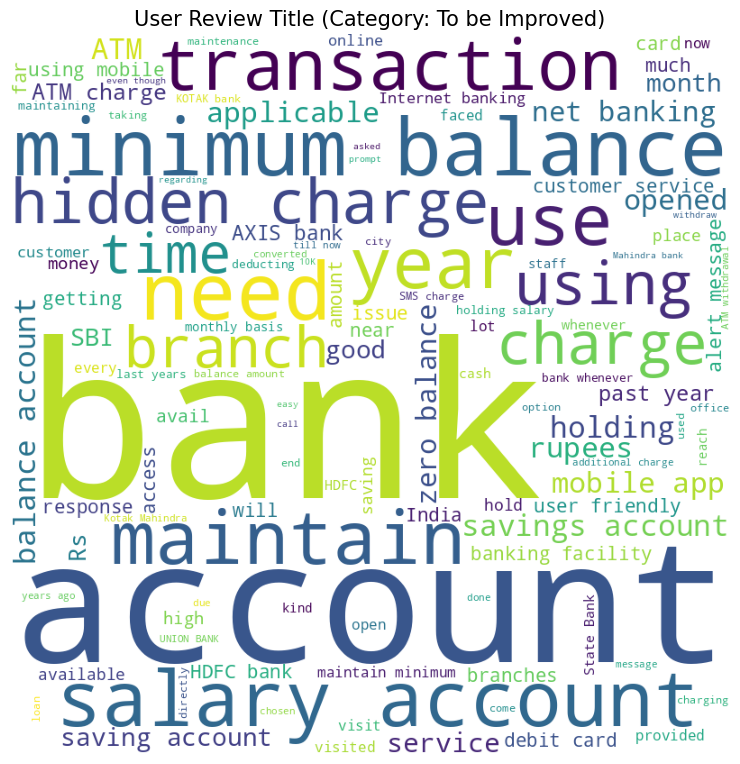

In [ ]:
data_copy = data.copy()
data_copy = data[data['Sentiment_Category']=='To be Improved']

combined_tobeImproved = ' '.join(data_copy['review'])


# create a word cloud using the combined text
wordcloud_tobeImproved = WordCloud(width = 800, height = 800,
                            background_color ='white',
                            min_font_size = 10).generate(combined_tobeImproved)

# plot the WordCloud image
plt.figure(figsize=(8,8))
plt.imshow(wordcloud_tobeImproved)
plt.axis('off')
plt.title('User Review Title (Category: To be Improved)', fontsize=15)
plt.tight_layout(pad=2)
plt.show()

In [ ]:
common_words = ['bank', 'account','salary','saving','savings','rupees']

pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, common_words)) + r')\b', flags=re.IGNORECASE)
filtered_string = pattern.sub('', combined_tobeImproved)

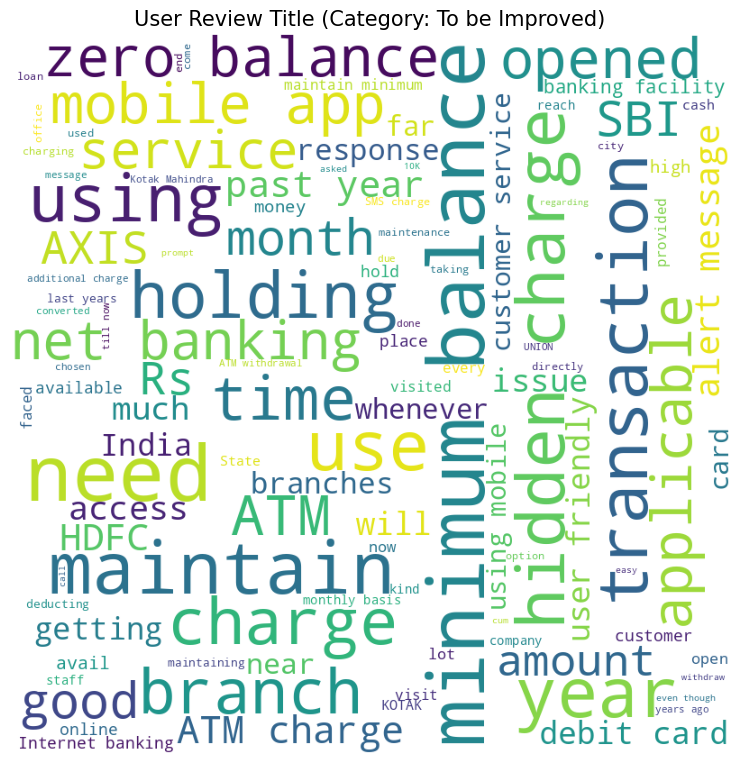

In [ ]:
# create a word cloud using the combined text
wordcloud_tobeImproved = WordCloud(width = 800, height = 800,
                            background_color ='white',
                            min_font_size = 10).generate(filtered_string)

# plot the WordCloud image
plt.figure(figsize=(8,8))
plt.imshow(wordcloud_tobeImproved)
plt.axis('off')
plt.title('User Review Title (Category: To be Improved)', fontsize=15)
plt.tight_layout(pad=2)
plt.show()

# Build model


In [ ]:
X = data.drop(columns=['rating'])
y = data[['rating']]

In [ ]:
y.value_counts()

,count
rating,
5.0,550
4.0,257
3.0,71
4.5,45
2.0,30
3.5,21
1.0,13
0.5,10
2.5,2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
temp = pd.concat([X_train, y_train], axis=1)
temp.head()

,author,date,address,bank,review_title_by_user,review,rating_title_by_user,useful_count,polarity,compound,Sentiment_Category,rating
828,TRUPTHI,"Dec 16, 2019",Bangalore,Axis Bank,"""Nice Account""",Holding my salary account from Axis bank and i...,Great!,0,"{'neg': 0.079, 'neu': 0.867, 'pos': 0.054, 'co...",-0.1027,To be Improved,4.0
468,Anonyms,"Jan 24, 2020",Kolkata,Unknow,"""Good Account""",I have opened the savings account in United Ba...,Great!,3,"{'neg': 0.0, 'neu': 0.897, 'pos': 0.103, 'comp...",0.6808,Neutral,4.0
207,ANONYMOUS,"Feb 28, 2020",Chennai,Canara Bank,"""Good Bank""",I have chosen my savings account from Canara b...,Blown Away!,5,"{'neg': 0.0, 'neu': 0.939, 'pos': 0.061, 'comp...",0.4404,Neutral,5.0
89,S KAMLESH,"Mar 12, 2020",Mumbai,Unknow,"""Best Service""",I am using Bank of Baroda salary account whi...,Blown Away!,2,"{'neg': 0.0, 'neu': 0.757, 'pos': 0.243, 'comp...",0.9410,Blown Away,5.0
706,MANJUNATH,"Dec 29, 2019",Chennai,Unknow,"""Good account""",I am having a salary account with Bank Of Indi...,Blown Away!,2,"{'neg': 0.0, 'neu': 0.9, 'pos': 0.1, 'compound...",0.5334,Neutral,5.0


In [ ]:
testData = pd.concat([X_test, y_test], axis=1)
testData.head()

,author,date,address,bank,review_title_by_user,review,rating_title_by_user,useful_count,polarity,compound,Sentiment_Category,rating
523,S BABARAM,"Jan 20, 2020",Thane,Unknow,"""Good Service""",I have Saraswat Cooperative Bank Salary acco...,Blown Away!,0,"{'neg': 0.0, 'neu': 0.845, 'pos': 0.155, 'comp...",0.7703,Neutral,5.0
804,SARVADE,"Dec 19, 2019",Hyderabad,HDFC Bank,"""Excellent service""",I am maintaining my salary account with HDFC a...,Blown Away!,0,"{'neg': 0.07, 'neu': 0.851, 'pos': 0.079, 'com...",0.1548,Neutral,5.0
284,UPADHAYAY,"Feb 18, 2020",Bangalore,Kotak,"""Good Account""",I have been using Kotak Mahindra bank salary a...,Great!,1,"{'neg': 0.0, 'neu': 0.964, 'pos': 0.036, 'comp...",0.2732,Neutral,4.0
945,ANONYMS,"Dec 03, 2019",Parvathipuram,Unknow,"""Good Service""",Andhra bank is a very good bank in providing s...,Blown Away!,1,"{'neg': 0.0, 'neu': 0.831, 'pos': 0.169, 'comp...",0.8618,Blown Away,5.0
560,N S,"Jan 16, 2020",Hyderabad,SBI,"""Everyone must have the national bank account""",My savings account was taken from State bank o...,Blown Away!,0,"{'neg': 0.036, 'neu': 0.964, 'pos': 0.0, 'comp...",-0.2732,To be Improved,5.0


In [ ]:
temp.shape

(750, 12)

In [ ]:
testData.shape

(250, 12)

In [ ]:
le = LabelEncoder()
for col in categoricalCol:
    temp[col] = le.fit_transform(temp[col])
temp.head()

,author,date,address,bank,review_title_by_user,review,rating_title_by_user,useful_count,polarity,compound,Sentiment_Category,rating
828,435,15,7,0,213,94,4,0,"{'neg': 0.079, 'neu': 0.867, 'pos': 0.054, 'co...",-0.1027,To be Improved,4.0
468,56,77,48,9,89,497,4,3,"{'neg': 0.0, 'neu': 0.897, 'pos': 0.103, 'comp...",0.6808,Neutral,4.0
207,35,54,13,1,94,443,1,5,"{'neg': 0.0, 'neu': 0.939, 'pos': 0.061, 'comp...",0.4404,Neutral,5.0
89,361,95,60,9,17,247,1,2,"{'neg': 0.0, 'neu': 0.757, 'pos': 0.243, 'comp...",0.9410,Blown Away,5.0
706,239,27,13,9,108,117,1,2,"{'neg': 0.0, 'neu': 0.9, 'pos': 0.1, 'compound...",0.5334,Neutral,5.0


In [ ]:
le = LabelEncoder()
for col in categoricalCol:
    testData[col] = le.fit_transform(testData[col])
testData.head()

,author,date,address,bank,review_title_by_user,review,rating_title_by_user,useful_count,polarity,compound,Sentiment_Category,rating
523,142,56,48,9,37,115,0,0,"{'neg': 0.0, 'neu': 0.845, 'pos': 0.155, 'comp...",0.7703,Neutral,5.0
804,155,13,20,3,28,74,0,0,"{'neg': 0.07, 'neu': 0.851, 'pos': 0.079, 'com...",0.1548,Neutral,5.0
284,175,33,5,6,33,143,3,1,"{'neg': 0.0, 'neu': 0.964, 'pos': 0.036, 'comp...",0.2732,Neutral,4.0
945,14,0,41,9,37,10,0,1,"{'neg': 0.0, 'neu': 0.831, 'pos': 0.169, 'comp...",0.8618,Blown Away,5.0
560,100,53,20,8,22,222,0,0,"{'neg': 0.036, 'neu': 0.964, 'pos': 0.0, 'comp...",-0.2732,To be Improved,5.0


In [ ]:
# Trích xuất giá trị 'pos' từ cột 'polarity'
temp['polarity_value'] = temp['polarity'].apply(lambda x: x['pos'])  # Hoặc x['neg'] hay x['neu'] tùy theo yêu cầu


In [ ]:
# Mã hóa cột Sentiment_Category
label_encoder = LabelEncoder()
temp['Sentiment_Category'] = label_encoder.fit_transform(temp['Sentiment_Category'])

# Mã hóa cột polarity thành các loại
temp['Polarity_Category'] = pd.cut(temp['polarity_value'], bins=[-1, 0.1, 0.9, 1],
                                    labels=['Negative', 'Neutral', 'Positive'])


In [ ]:
# Trích xuất giá trị 'pos' từ cột 'polarity'
testData['polarity_value'] = testData['polarity'].apply(lambda x: x['pos'])  # Hoặc x['neg'] hay x['neu'] tùy theo yêu cầu


In [ ]:
# Mã hóa cột Sentiment_Category
label_encoder = LabelEncoder()
testData['Sentiment_Category'] = label_encoder.fit_transform(testData['Sentiment_Category'])

# Mã hóa cột polarity thành các loại
testData['Polarity_Category'] = pd.cut(testData['polarity_value'], bins=[-1, 0.1, 0.9, 1],
                                    labels=['Negative', 'Neutral', 'Positive'])


In [ ]:
temp.head()

,author,date,address,bank,review_title_by_user,review,rating_title_by_user,useful_count,polarity,compound,Sentiment_Category,rating,polarity_value,Polarity_Category
828,435,15,7,0,213,94,4,0,"{'neg': 0.079, 'neu': 0.867, 'pos': 0.054, 'co...",-0.1027,2,4.0,0.054,Negative
468,56,77,48,9,89,497,4,3,"{'neg': 0.0, 'neu': 0.897, 'pos': 0.103, 'comp...",0.6808,1,4.0,0.103,Neutral
207,35,54,13,1,94,443,1,5,"{'neg': 0.0, 'neu': 0.939, 'pos': 0.061, 'comp...",0.4404,1,5.0,0.061,Negative
89,361,95,60,9,17,247,1,2,"{'neg': 0.0, 'neu': 0.757, 'pos': 0.243, 'comp...",0.9410,0,5.0,0.243,Neutral
706,239,27,13,9,108,117,1,2,"{'neg': 0.0, 'neu': 0.9, 'pos': 0.1, 'compound...",0.5334,1,5.0,0.100,Negative


In [ ]:
temp = temp.drop(columns=['polarity', 'Polarity_Category'])
testData= testData.drop(columns=['polarity', 'Polarity_Category'])

In [ ]:
X_train = temp.drop('rating', axis=1)
y_train = temp['rating']

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)


In [ ]:
X_train

array([[ 1.50768569, -1.29635266, -0.95557423, ..., -0.94798348,
         1.48460434, -0.71680383],
       [-1.10524396,  0.68890616,  0.63618674, ...,  0.69226567,
        -0.05331452, -0.00501641],
       [-1.25002371, -0.04756082, -0.7226336 , ...,  0.18899076,
        -0.05331452, -0.61511991],
       ...,
       [-0.98114704,  0.46476403, -0.56733985, ...,  0.22751097,
        -0.05331452, -0.33912071],
       [-0.14693995,  0.40072342,  0.24795236, ..., -0.94798348,
         1.48460434, -1.03638185],
       [-1.20865807,  1.26527162,  0.24795236, ..., -0.78699412,
         1.48460434, -0.64417246]])

In [ ]:
pca = PCA(n_components = 8)
pca.fit_transform(X_train);

In [ ]:
pca.explained_variance_ratio_

array([0.25231616, 0.12290234, 0.10327419, 0.09921145, 0.09291795,
       0.08225492, 0.07989559, 0.07345705])

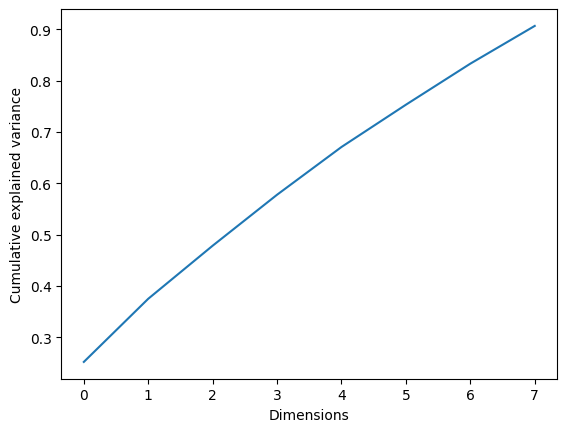

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Dimensions')
plt.ylabel('Cumulative explained variance');

In [ ]:
temp['kFold'] = -1

In [ ]:
temp.head()

,author,date,address,bank,review_title_by_user,review,rating_title_by_user,useful_count,compound,Sentiment_Category,rating,polarity_value,kFold
828,435,15,7,0,213,94,4,0,-0.1027,2,4.0,0.054,-1
468,56,77,48,9,89,497,4,3,0.6808,1,4.0,0.103,-1
207,35,54,13,1,94,443,1,5,0.4404,1,5.0,0.061,-1
89,361,95,60,9,17,247,1,2,0.9410,0,5.0,0.243,-1
706,239,27,13,9,108,117,1,2,0.5334,1,5.0,0.100,-1


In [ ]:
X_test = testData.drop('rating', axis=1)
y_test = testData['rating']

In [ ]:
y_train

,rating
828,4.0
468,4.0
207,5.0
89,5.0
706,5.0
...,...
421,5.0
180,4.0
545,5.0
570,5.0


In [ ]:
y_train = np.where(y_train <= 3.0, 'bad',
                   np.where(y_train >= 4.0, 'good', 'neutral'))

y_test = np.where(y_test <= 3.0, 'bad',
                  np.where(y_test >= 4.0, 'good', 'neutral'))


In [ ]:
X_test = scaler.transform(X_test)

In [ ]:
y_test

array(['good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'bad', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'bad', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'bad',
       'good', 'good', 'bad', 'good', 'good', 'good', 'good', 'neutral',
       'good', 'good', 'good', 'good', 'bad', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'bad', 'bad', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'neutral', 'good', 'good', 'good', 'good', 'good',
       'good', 'bad', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       '

In [ ]:
# Huấn luyện mô hình
model = LogisticRegression()
model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
pred = model.predict(X_test)

In [ ]:
report = classification_report(y_test, pred)
print(report)

              precision    recall  f1-score   support

         bad       0.97      0.82      0.89        34
        good       0.97      1.00      0.98       214
     neutral       0.00      0.00      0.00         2

    accuracy                           0.97       250
   macro avg       0.64      0.61      0.62       250
weighted avg       0.96      0.97      0.96       250



In [ ]:
rf_model = RandomForestClassifier(random_state=12)
rf_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
rf_pred = rf_model.predict(X_test)

# In ra bảng report
rf_report = classification_report(y_test, rf_pred, target_names=['bad', 'good', 'neutral'])
print(rf_report)

              precision    recall  f1-score   support

         bad       1.00      0.82      0.90        34
        good       0.97      1.00      0.99       214
     neutral       1.00      1.00      1.00         2

    accuracy                           0.98       250
   macro avg       0.99      0.94      0.96       250
weighted avg       0.98      0.98      0.98       250



In [ ]:

# Huấn luyện mô hình CatBoost
catboost_model = CatBoostClassifier(iterations=1000,
                                     learning_rate=0.1,
                                     depth=6,
                                     verbose=0)  # Set verbose=0 to suppress output
catboost_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
catboost_pred = catboost_model.predict(X_test)

# In ra bảng report
catboost_report = classification_report(y_test, catboost_pred, target_names=['bad', 'good', 'neutral'])
print(catboost_report)


              precision    recall  f1-score   support

         bad       0.31      0.82      0.45        34
        good       0.96      0.71      0.82       214
     neutral       1.00      1.00      1.00         2

    accuracy                           0.73       250
   macro avg       0.76      0.84      0.76       250
weighted avg       0.87      0.73      0.77       250



Tuning Catboots

In [ ]:
def objective(trial):
    # Hyperparameter tuning
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_state': 42,
        'verbose': 0
    }

    # Train the CatBoost model
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)

    # Make predictions and calculate F1 score
    preds = model.predict(X_test)  # Assume you have a validation set
    f1 = f1_score(y_test, preds, average='weighted')

    return f1

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Adjust the number of trials as needed

[I 2024-09-23 07:34:47,765] A new study created in memory with name: no-name-3b9a9bf1-5f90-48c5-ae5d-7717b61abdde
[I 2024-09-23 07:35:02,678] Trial 0 finished with value: 0.794497277676951 and parameters: {'iterations': 683, 'learning_rate': 0.014008696978736915, 'depth': 8, 'l2_leaf_reg': 6.178377411932642}. Best is trial 0 with value: 0.794497277676951.
[I 2024-09-23 07:35:04,094] Trial 1 finished with value: 0.7753674059787847 and parameters: {'iterations': 299, 'learning_rate': 0.26936032125009984, 'depth': 6, 'l2_leaf_reg': 5.049083993653255}. Best is trial 0 with value: 0.794497277676951.
[I 2024-09-23 07:35:05,840] Trial 2 finished with value: 0.7560217391304348 and parameters: {'iterations': 244, 'learning_rate': 0.2707228060075779, 'depth': 7, 'l2_leaf_reg': 9.516531095798246}. Best is trial 0 with value: 0.794497277676951.
[I 2024-09-23 07:35:06,849] Trial 3 finished with value: 0.7753674059787847 and parameters: {'iterations': 637, 'learning_rate': 0.018630973291842177, 'dep

In [ ]:
best_params = study.best_params
print("Best parameters:", best_params)


Best parameters: {'iterations': 683, 'learning_rate': 0.014008696978736915, 'depth': 8, 'l2_leaf_reg': 6.178377411932642}


In [ ]:
final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train)

# Optionally, evaluate the model on the test set
final_preds = final_model.predict(X_test)
final_report = classification_report(y_test, final_preds, target_names=['bad', 'good', 'neutral'])
print(final_report)


0:	learn: 1.0839822	total: 12.9ms	remaining: 8.8s
1:	learn: 1.0660937	total: 26.1ms	remaining: 8.9s
2:	learn: 1.0538246	total: 38.8ms	remaining: 8.79s
3:	learn: 1.0388745	total: 51.5ms	remaining: 8.74s
4:	learn: 1.0219615	total: 64.4ms	remaining: 8.73s
5:	learn: 1.0086733	total: 77.3ms	remaining: 8.72s
6:	learn: 0.9957134	total: 90ms	remaining: 8.69s
7:	learn: 0.9827888	total: 103ms	remaining: 8.67s
8:	learn: 0.9707548	total: 116ms	remaining: 8.67s
9:	learn: 0.9603254	total: 129ms	remaining: 8.65s
10:	learn: 0.9490255	total: 141ms	remaining: 8.63s
11:	learn: 0.9374810	total: 154ms	remaining: 8.63s
12:	learn: 0.9246900	total: 167ms	remaining: 8.61s
13:	learn: 0.9101462	total: 170ms	remaining: 8.1s
14:	learn: 0.8977154	total: 182ms	remaining: 8.1s
15:	learn: 0.8869795	total: 195ms	remaining: 8.13s
16:	learn: 0.8759235	total: 208ms	remaining: 8.16s
17:	learn: 0.8642406	total: 229ms	remaining: 8.45s
18:	learn: 0.8548043	total: 242ms	remaining: 8.45s
19:	learn: 0.8444809	total: 256ms	remain